# Analyzing Austin's Housing Market

This notebook has the purpose of analyzing patterns in Austin's Housing Market. For this, we will analyze historical data and trends regarding the city of Austin and its housing market. Our primary objective is to identify present trends in the city's housing market and identify whether the city is facing a market cooldown or not. To achieve this, we have gathered various datasets from different sources (cited below) and analyzed variables like population growth, housing prices, and residence supply. We aim to reveal the roles of these variables in the city's housing market and potentially forecasting future trends. 

**Data Sources:**

- **Austin Metro Area Population from 1950 to 2024:** https://www.macrotrends.net/global-metrics/cities/22926/austin/population#:~:text=The%20current%20metro%20area%20population,a%202.39%25%20increase%20from%202022.
  
- **Housing Price Index Values per State:** https://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_AT_state.csv

- **Historical Home Value Dataset:** https://www.zillow.com/research/data/ (home value forecasts dataset)

- **Issued Construction Permits for the City of Austin (by way of API):** https://data.austintexas.gov/Building-and-Development/Issued-Construction-Permits/3syk-w9eu/about_data

## Inspect Data and Code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import numpy as np
import folium
from folium.plugins import HeatMap

In [2]:
df = pd.read_csv("Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29
0,102001,0,United States,country,NaN,120033.213118,120244.390020,120506.280472,121067.984085,121714.437600,...,338064.442178,339983.429822,341714.499308,343320.857702,344534.468791,345442.620280,346085.974435,346512.924624,346937.795092,347716.403521
1,394913,1,"New York, NY",msa,NY,214314.541751,215225.257633,216144.408385,218006.963476,219935.703774,...,606745.123196,610879.614267,614451.352435,617722.772446,620426.482744,622753.723017,625046.489171,627786.764568,630647.129893,634651.292334
2,753899,2,"Los Angeles, CA",msa,CA,225004.543761,225841.846147,226957.124939,229176.155088,231603.078401,...,865780.165600,873714.456232,885120.397731,898920.602973,912854.603160,924447.808547,933172.335731,938650.917713,938807.281178,935800.633156
3,394463,3,"Chicago, IL",msa,IL,149670.248748,149808.799798,150072.672713,150729.122949,151518.753624,...,291175.593589,293687.070581,296179.313451,298585.663841,300379.190860,301714.515123,302609.391434,303230.292185,303876.121795,305231.331105
4,394514,4,"Dallas, TX",msa,TX,125827.184072,125883.227939,125947.656102,126114.969273,126335.567108,...,368490.454585,369308.974989,370286.444771,371208.787782,371624.028109,371738.581242,371599.789839,371273.692516,371295.346287,371776.654871


This data contains housing prices across different regions. We will extract Austin's housing prices, as well as the National Average. This will help us visualize how Austin's housing prices have increased in relation to the National Average. Below, a line graph has been established:

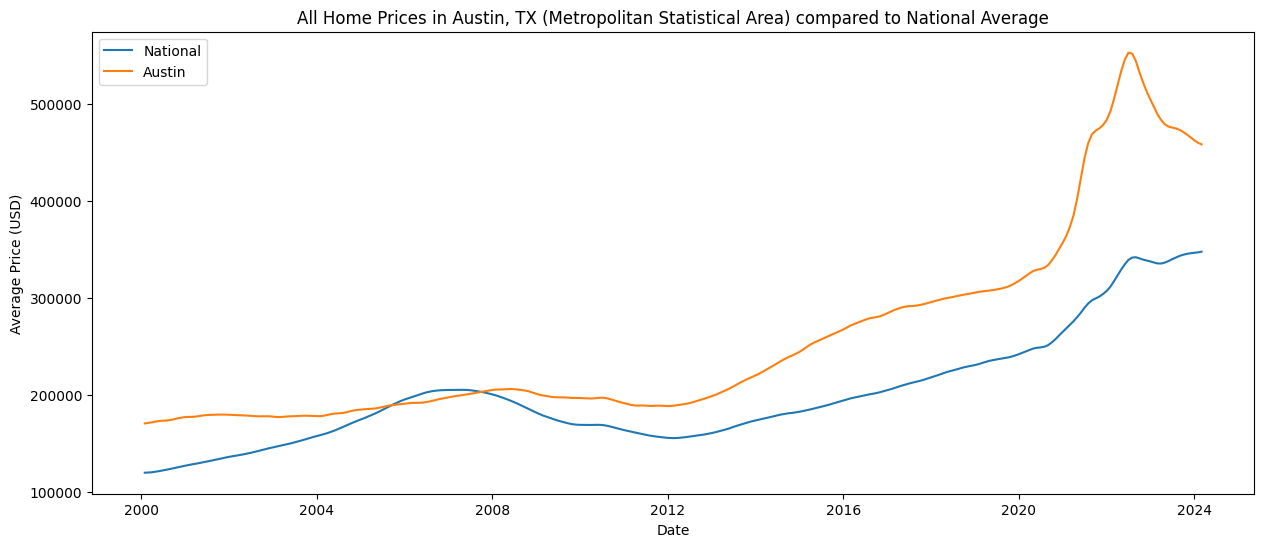

In [3]:
atx_data = df[(df["RegionName"] == "Austin, TX") | (df["RegionName"] == "United States")]
atx_data = atx_data.drop(columns=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'])
atx_data = atx_data.transpose()
atx_data.index = pd.to_datetime(atx_data.index)
plt.figure(figsize=(15, 6))
plt.title("All Home Prices in Austin, TX (Metropolitan Statistical Area) compared to National Average")
plt.xlabel("Date")
plt.ylabel("Average Price (USD)")
plt.plot(atx_data.index, atx_data, label=["National", "Austin"])
plt.legend();

- **Comparative Analysis:** Both lines show a general upward trend over time, indicating that the average home prices in both Austin and the National average have been increasing. After 2008, Austin's housing prices have increased above the National Average. Although there is an upward trend in housing prices, Austin's housing prices are above the national average. There was a sharp increase in Austin's housing prices in 2020 compared to the national average. This divergence highlights how the large population increase in the pandemic affected Austin's housing prices. This population increase was due to several factors like increased demand, changes in employment opportunities (like the significant growth in Austin's tech industry), or Austin becoming a popular city for relocating.

- **Sharp Increase and Decrease in Austin:** The sharp peak and subsequent drop in the Austin line indicate a very rapid increase in prices followed by a sharp decrease around 2023-2024. This could be indicative of a bubble where prices rose unsustainably quickly and then corrected, or it could reflect a rapid change in local conditions, such as a sudden increase in supply, economic downturn, or policy changes.

- **Recent Trends:** Most recently, after the sharp decrease, the Austin price line seems to be either stabilizing or beginning to increase again but has not returned to the extreme peak seen just prior.

- **Volatility:** The Austin line shows more volatility than the National average, especially in recent years, indicating that the Austin market might be more sensitive to local or external shocks.

Based on this graph, one could investigate further into what happened in Austin around 2020-2024 that caused such a marked increase in home prices and then the following decline. Factors like local economic conditions, housing market policies, interest rates, and the broader national economic climate would all be areas to explore.

## How has the effect of Austin's boom affected Texas's Housing Price Index Value?

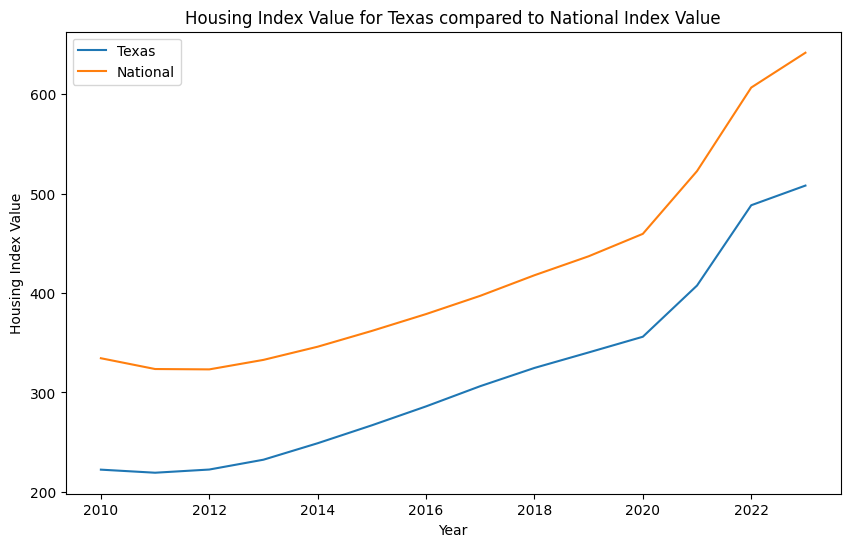

In [4]:
# How has the effect of austin's boom affected texas's value in idx

home_sales = pd.read_csv("HPI_AT_state.csv")
home_sales = home_sales.shift(1)
first_entry = home_sales.columns
first_entry = [float(first_entry[i]) if i > 0 else str(first_entry[i]) for i in range(len(first_entry))]
home_sales.iloc[0] = first_entry
home_sales = home_sales.rename(columns={"AK":"State", "1975":"Year", "1":"Quarter", "61.66":"Value"})
home_sales["Year"] = pd.to_datetime(home_sales["Year"], format="%Y")
home_sales["Year"] = home_sales["Year"].dt.year
home_sales["Quarter"] = home_sales["Quarter"].astype(int)

home_sales_2010_2023 = home_sales[home_sales["Year"] > 2009]
texas_sales = home_sales_2010_2023[home_sales_2010_2023["State"] == "TX"]
average_sales_texas = texas_sales.groupby("Year")["Value"].mean().reset_index()

nationwide_sales = home_sales_2010_2023[home_sales_2010_2023["State"] != "TX"]
average_nationwide_sales = nationwide_sales.groupby("Year")["Value"].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.xlabel("Year")
plt.ylabel("Housing Index Value")
plt.title("Housing Index Value for Texas compared to National Index Value")
plt.plot(average_sales_texas["Year"], average_sales_texas["Value"], label="Texas")
plt.plot(average_nationwide_sales["Year"], average_nationwide_sales["Value"], label="National")
plt.legend();

- **Trends:** The movement in the Housing Index Value for Texas is highly similar to the National Average. This suggests the upward trend in Austin's housing prices has not increased the Housing Index Value for Texas as a whole.

- **Localized Market Dynamics:** The Texas line suggests that the price increase in Austin's housing is related to Austin, not Texas itself. While Texas tracks closely with the national trend, Austin may experience different market dynamics that don't necessarily shift the state-wide average in the same manner. Texas is a large state with a high economic diversity. Each of its cities like Dallas, San Antonio, Houston, and Austin contribute differently to the housing market based on their varied economic drivers. Other factors that contribute to Austin's sharp increase may include its limited supply in relation to its increased housing demand, due to population growth, which will be analyzed below. 

## How is the supply for Residences looking in Austin?

Taken directly from Austin's provided by the city of Austin, we will look at the increase in housing supply by analyzing residential construction permits from November 2023 to today's date.

In [5]:
construction_df = pd.read_csv("https://data.austintexas.gov/resource/3syk-w9eu.csv?permittype=BP&permit_class_mapped=Residential&work_class=New&status_current=Active")

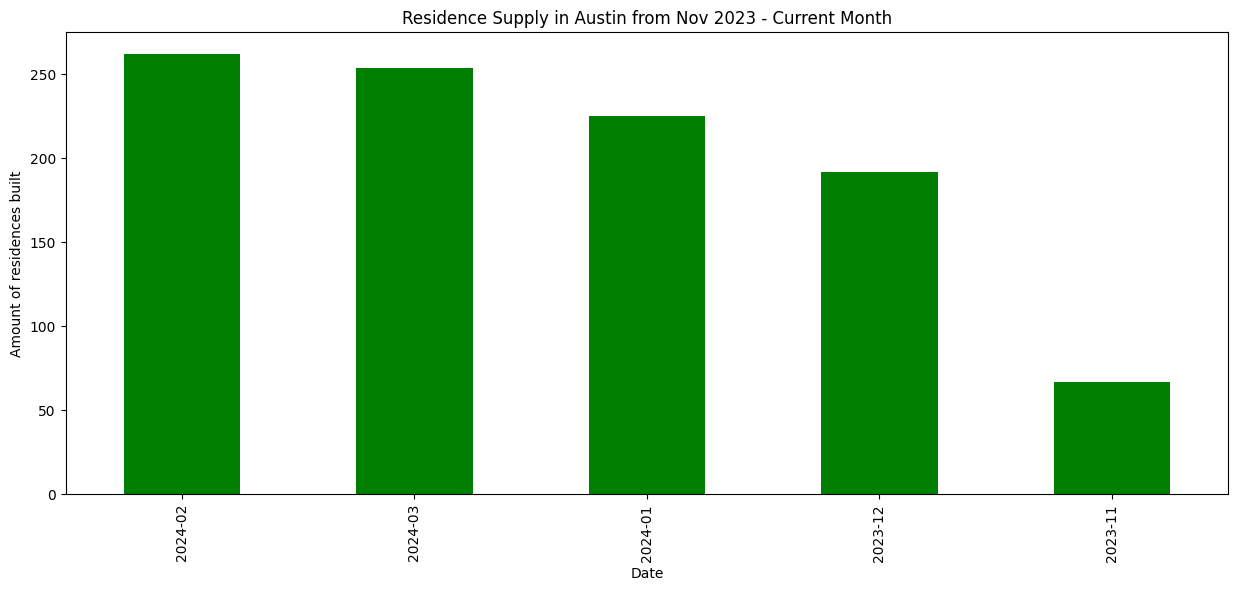

In [6]:
construction_df["issue_date"] = pd.to_datetime(construction_df["issue_date"])
construction_df['year_month'] = construction_df['issue_date'].dt.strftime('%Y-%m')
plt.figure(figsize=(15, 6))
plt.title("Residence Supply in Austin from Nov 2023 - Current Month")
plt.ylabel("Amount of residences built")
construction_df.year_month.value_counts().plot(kind="bar", color="green")
plt.xlabel("Date");

- **Trends:** There is a downward trend in the volume of new residences built over this four month period. This decrease may be due to factors not neccesarily related to a decline in population growth, like holidays or less favorable weather conditions. 

- **Potential Market Reaction:** If the supply continues to slow down, it could be due to the market response of a percieved oversupply or diminishing demand. However, other factors may contribute to the reduced supply like material shortages or labor issues.

- **Other Indicators:** This reduced supply serves as a significant economic indicator. This decrease implies the cooling off of the housing market in Austin we have seen might be true.

## Percentage increase (decrease) in Austin's housing supply

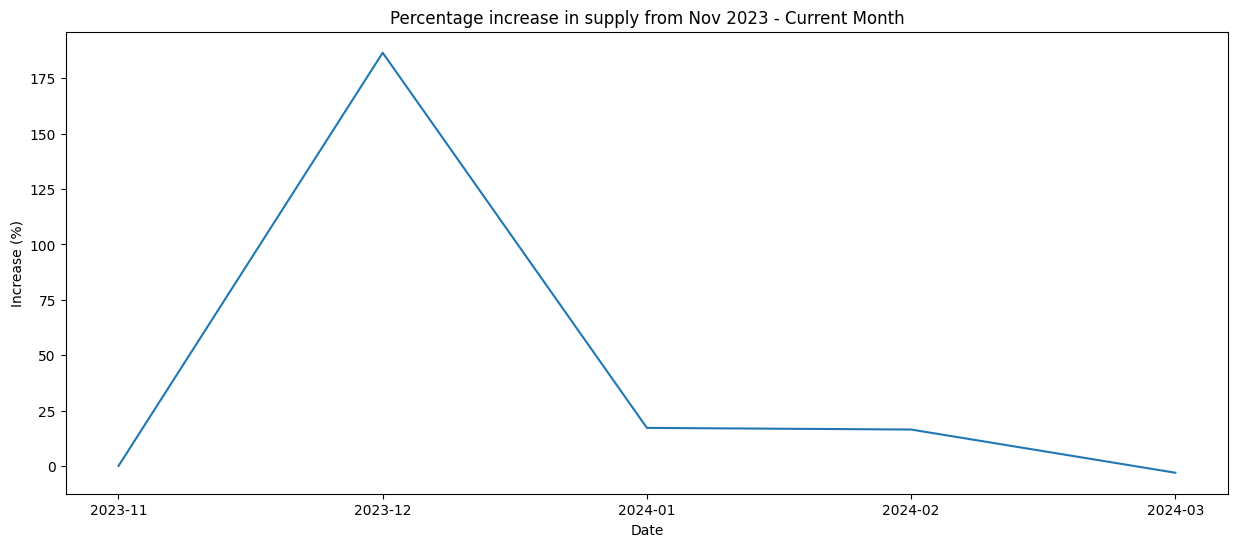

In [7]:
ym_value_counts = construction_df["year_month"].value_counts().reset_index()
ym_value_counts.columns = ['year_month', 'count']


ym_value_counts['year_month'] = pd.to_datetime(ym_value_counts['year_month'])
ym_value_counts['year_month'] = ym_value_counts['year_month'].dt.strftime('%Y-%m')

ym_value_counts = ym_value_counts.sort_values(by='year_month')
ym_value_counts.sort_values(by='year_month')
ym_value_counts["count"] = ym_value_counts["count"].pct_change()
ym_value_counts.iloc[0,1] = 0
plt.figure(figsize=(15, 6))
plt.title("Percentage increase in supply from Nov 2023 - Current Month")
plt.xlabel("Date")
plt.ylabel("Increase (%)")
percentages = [pct*100 for pct in ym_value_counts["count"]]
plt.plot(ym_value_counts["year_month"], percentages);

- **Trends:** There's a sharp increase in residence supply from November 2023 to December 2023. This suggests a significant rise in construction during this period. After December 2023, there's a peak followed by a steep decline in the percentage increase of residences built. This could imply there has been market saturation or the cooling in the housing market we have seen happening. Between February and March, there is stabilization in the curve, which may mean the supply is adjusting with the demand.

## Where are these houses located?

In [8]:
heat_data = construction_df[['latitude', 'longitude']].values.tolist()

map_austin = folium.Map(location=[30.2672, -97.7431], zoom_start=11)

HeatMap(heat_data).add_to(map_austin)
# map_austin.save('austin_heatmap.html')  # Uncomment to save the map to an HTML file

map_austin

- The heatmap indicates that residential construction permits are being issued around Central Austin. As the data indicates, South and Southeast Austin have seen the biggest surge in residential construction permits. This suggests that we will see more houses being built in these areas and a likely anticipation of higher demand for residential spaces.

## The trend to build residential spaces in Austin keeps on going, but is the population growing as well?

In [9]:
# population from 2000 to 2024
population_df = pd.read_csv("Austin-population-2024-03-25.csv")[50:76]
population_df.head()

,date,Population,Annual Change
50,12/31/00,911000,4.71
51,12/31/01,950000,4.28
52,12/31/02,990000,4.21
53,12/31/03,1031000,4.14
54,12/31/04,1075000,4.27


In [10]:
population_df["date"] = pd.to_datetime(population_df["date"], format='%m/%d/%y')
population_df['year'] = population_df['date'].dt.strftime('%Y')
population_df.head()

,date,Population,Annual Change,year
50,2000-12-31,911000,4.71,2000
51,2001-12-31,950000,4.28,2001
52,2002-12-31,990000,4.21,2002
53,2003-12-31,1031000,4.14,2003
54,2004-12-31,1075000,4.27,2004


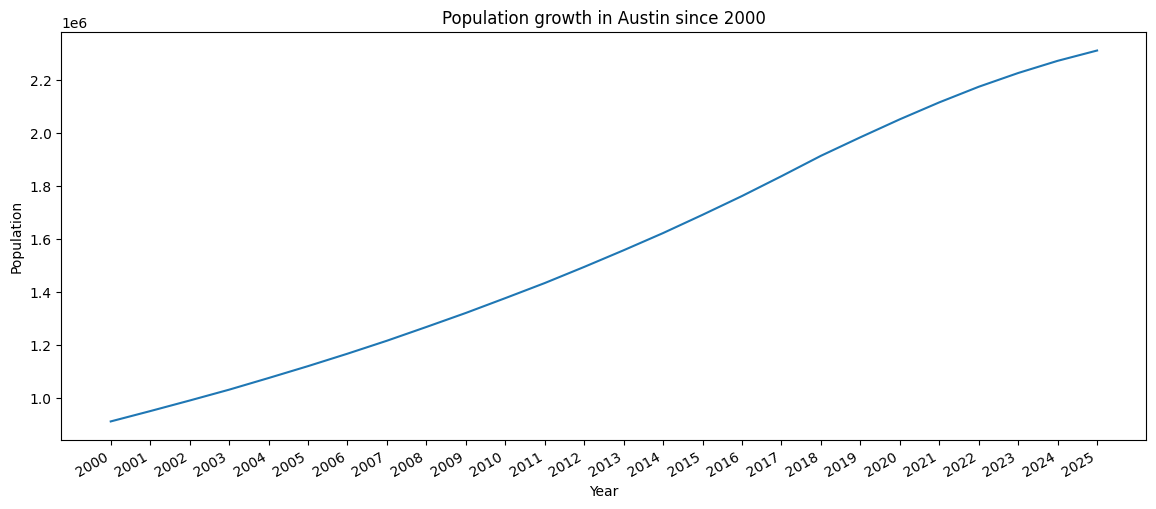

In [11]:
plt.figure(figsize=(14, 6))
plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Population growth in Austin since 2000")
plt.plot(population_df['year'], population_df[' Population'])
plt.gcf().autofmt_xdate()

- **Trends:** Since the year 2000, there has been a continuous increase in Austin's population, providing basis for the extended supply of housing in the city. Although the population has continued to grow, it is still disproportionate to the prices we have seen lately in its housing market. The comparison between housing prices and population growth better illustrates this situation.

## How does the percentage change in Austin's population compare against its increase in home prices?

In [12]:
texas_home_sales = home_sales[(home_sales["State"] == "TX") & (home_sales["Year"] > 1998)]
yearly_values = texas_home_sales.groupby("Year")["Value"].mean()
yearly_pct = yearly_values.pct_change()
yearly_pct = yearly_pct[1:].reset_index()
yearly_pct["Year"] = pd.to_datetime(yearly_pct["Year"], format='%Y').dt.strftime('%Y')
yearly_pct.head()

,Year,Value
0,2000,0.061056
1,2001,0.066460
2,2002,0.035563
3,2003,0.030778
4,2004,0.027415


In [13]:
atx_data = df[(df["RegionName"] == "Austin, TX")]
atx_data = atx_data.drop(columns=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'])
atx_data = atx_data.transpose()
atx_data.index = pd.to_datetime(atx_data.index)
atx_data.index = atx_data.index.strftime('%Y')
atx_yearly = atx_data.groupby(atx_data.index).mean()
atx_yearly_pct = atx_yearly.pct_change().reset_index()
atx_yearly_pct = atx_yearly_pct.rename({29.0:"Percent_Change"}, axis=1)
atx_yearly_pct.head()

,index,Percent_Change
0,2000,NaN
1,2001,0.029620
2,2002,-0.002416
3,2003,-0.002505
4,2004,0.019374


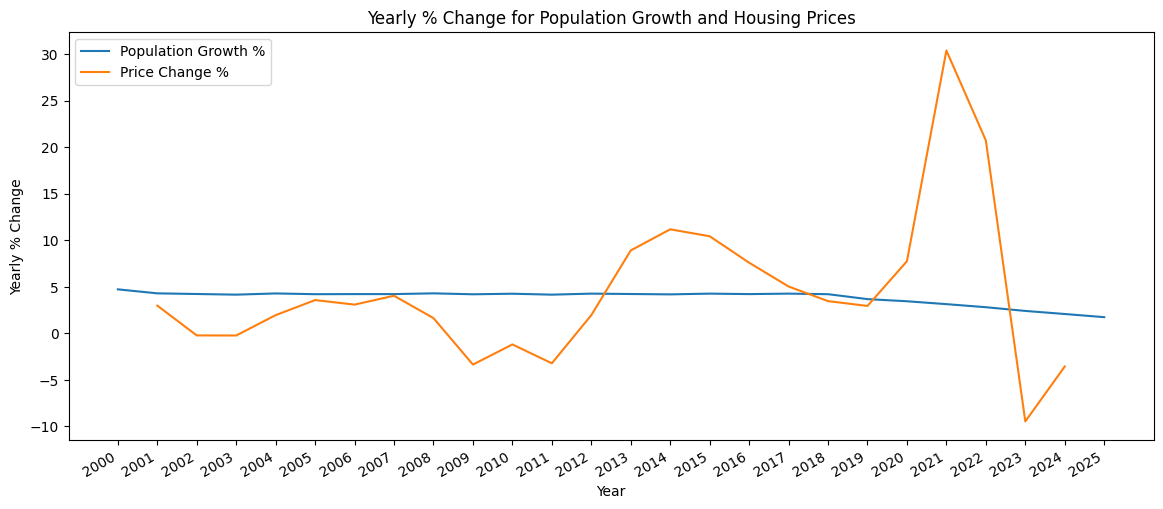

In [14]:
plt.figure(figsize=(14, 6))
plt.xlabel("Year")
plt.ylabel("Yearly % Change")
plt.title("Yearly % Change for Population Growth and Housing Prices")
percentage_change_prices = [pct * 100 for pct in atx_yearly_pct["Percent_Change"]]
plt.plot(population_df['year'], population_df[' Annual Change'], label="Population Growth %")
plt.plot(atx_yearly_pct["index"], percentage_change_prices, label="Price Change %")

plt.gcf().autofmt_xdate()
plt.legend();

### To better interpret the graph, let's look at the % difference between these two variables

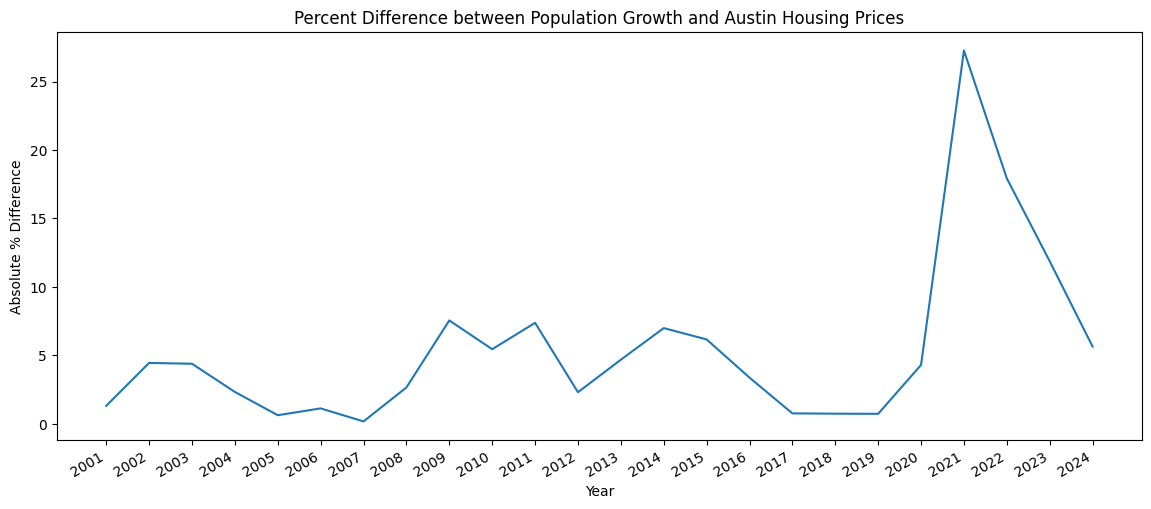

In [15]:
percentage_difference = abs(np.subtract(percentage_change_prices[1:], population_df[' Annual Change'][1:-1]))
plt.figure(figsize=(14, 6))
plt.xlabel("Year")
plt.ylabel("Absolute % Difference")
plt.title("Percent Difference between Population Growth and Austin Housing Prices")
plt.plot(atx_yearly_pct["index"][1:], percentage_difference)
plt.gcf().autofmt_xdate()

Our graph displays the absolute difference these two variables. Historically, these increases have not been proportionate. The first graph highlights how the population has been steadily growing by 5% while the housing prices have been fluctuating significantly. Our most drastic increase occured in 2021, when housing prices increased by 30%. On top of this, housing prices grew by 20%. After this, prices in 2023 and 2024 have been decreasing by 9% and 3% respectively. These decreases have not been proportionate to the sharp increases in these two years, meaning housing prices have still not adjusted to the demand in Austin. As the graph suggests, in 2023 there was a difference between prices and population growth of more than 11%, which means housing prices have not adjusted to demand and that we will still be seeing elevated housing prices in Austin. Although there has been increased supply in Austin's housing market, the prices have not been adjusted to Austin's steady population growth. 


- **Housing Demand:** The rise in population blew disproportionately the housing prices in the city. The increased population in Austin intensified the housing market, which led to increased housing prices.

- **Sharp Increase:** The dramatic spike in 2020 suggests how housing prices surged with the increased population growth during the pandemic due to increased remote work and a shift in market preferences.

- **Rapid Correction:** The spike is followed by a rapid decline, which points to a price reduction, but not an overall correction of market prices, as the housing prices have not increased in proportion to the population over time; the rapid escalation was not fully sustained over time. If the market adjusts, we may see a reduction in housing prices in proportion to population growth.

- **Austin's Housing Market Volatility:** This period of sharp increases and declines highlights a period of volatility in Austin's housing market, as the housing prices were highly disproportionate to the population growth. 

- **Supply and Demand:** The spike suggests how housing prices increased during the pandemic. This means that the supply did not keep up with the demand in housing during the pandemic. However, the rapid decline during the past couple of years reflects a cooling of the housing market: either because of the increased supply or overbuilding or because of a reduced demand.

- **Supply and Demand Dynamics:** The spike could suggest that while the supply of housing may have been increasing, it didn't keep pace with the growth in housing demand, possibly influenced by the pandemic. The decline might then reflect a cooling off of that demand or an increase in housing supply.

## Conclusion:

To conclude this analysis, we have seen there is significant evidence of cooling in Austin's housing market. Despite the reduction in population growth, housing prices still remain inflated, presenting affordability challenges for residents. As we have seen, this cooling trend was caused by a reduced population growth (compared to the recent pandemic years) and an influx of housing supply (overbuilding). 

While there has been a recent cooling, it is important to consider the long-term sustainability of the housing market in Austin. It is still unknown if prices will continue to adjust downwards, or if the cooling is just a temporary response to short-term market shocks. Even though this is the case, this situation still presents affordability challenges to residents, especially to first-time homebuyers. The market still needs to be observed to identify whether this is a trend towards a more balanced market or just a dip in an upward trajectory. Also, the need for it to be observed closely stems from various factors that influence the prices of residences. Things like migration patterns, interest rates, and employment opportunities influence the direction of the market.